In [77]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import os

In [78]:
# Step 1: Load Pretrained Model
model = InceptionV3(weights='imagenet')
layer_name = 'mixed10'  # Layer to get activations from

intermediate_model = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer(layer_name).output
)

In [79]:
# Step 2: Load a local zebra image
img_path = '/content/zebra.jpg'
img = load_img(img_path, target_size=(299, 299))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print("Prediction:", decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: [('n02391049', 'zebra', np.float32(0.93795544)), ('n02422106', 'hartebeest', np.float32(0.001263666)), ('n01518878', 'ostrich', np.float32(0.0008051919))]


In [80]:
# Step 3: Generate synthetic "striped" concept images
def generate_striped_images(num=20):
    images = []
    for _ in range(num):
        img = np.zeros((299, 299, 3), dtype=np.uint8)
        for i in range(0, 299, 10):
            img[:, i:i+5, :] = 255  # white vertical stripes
        images.append(preprocess_input(np.expand_dims(img, axis=0)))
    return np.vstack(images)

striped_images = generate_striped_images(20)

In [81]:
# Step 4: Extract activations
concept_activations = intermediate_model.predict(striped_images)
image_activations = intermediate_model.predict(x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [82]:
# Step 5: Train CAV (Concept Activation Vector)
X = np.concatenate([concept_activations, np.random.normal(size=concept_activations.shape)])
y = np.array([1] * len(concept_activations) + [0] * len(concept_activations))

X_flat = X.reshape(X.shape[0], -1)
clf = SGDClassifier().fit(X_flat, y)
cav = clf.coef_.reshape(concept_activations.shape[1:])

In [83]:
# Step 6: Compute directional derivative
image_activ_flat = image_activations.reshape(-1)
cav_flat = cav.reshape(-1)
directional_derivative = np.dot(image_activ_flat, cav_flat)
print(f"Directional derivative: {directional_derivative:.4f}")

Directional derivative: 67553.6096


In [84]:
# Step 7: TCAV Score: high means concept strongly influences the prediction
tcav_score = np.mean([np.dot(act.reshape(-1), cav_flat) > 0 for act in concept_activations])
print(f"TCAV Score for 'striped' concept influencing 'zebra': {tcav_score:.2f}")

TCAV Score for 'striped' concept influencing 'zebra': 1.00


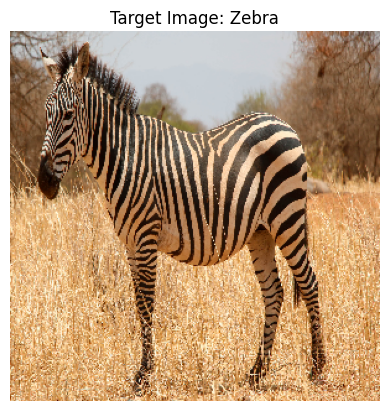

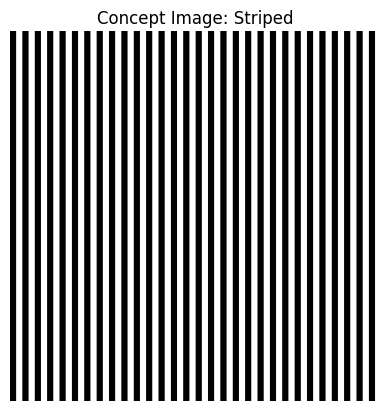

In [85]:
# Step 8: Visualize
plt.imshow(img)
plt.title("Target Image: Zebra")
plt.axis('off')
plt.show()

# Visualize a striped concept
plt.imshow(generate_striped_images(1)[0].astype(np.uint8))
plt.title("Concept Image: Striped")
plt.axis('off')
plt.show()

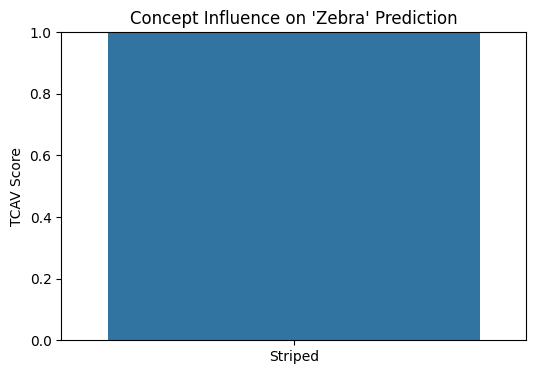

In [86]:
import seaborn as sns

# Plotting TCAV Score
plt.figure(figsize=(6, 4))
sns.barplot(x=['Striped'], y=[tcav_score])
plt.ylim(0, 1)
plt.ylabel("TCAV Score")
plt.title("Concept Influence on 'Zebra' Prediction")
plt.show()


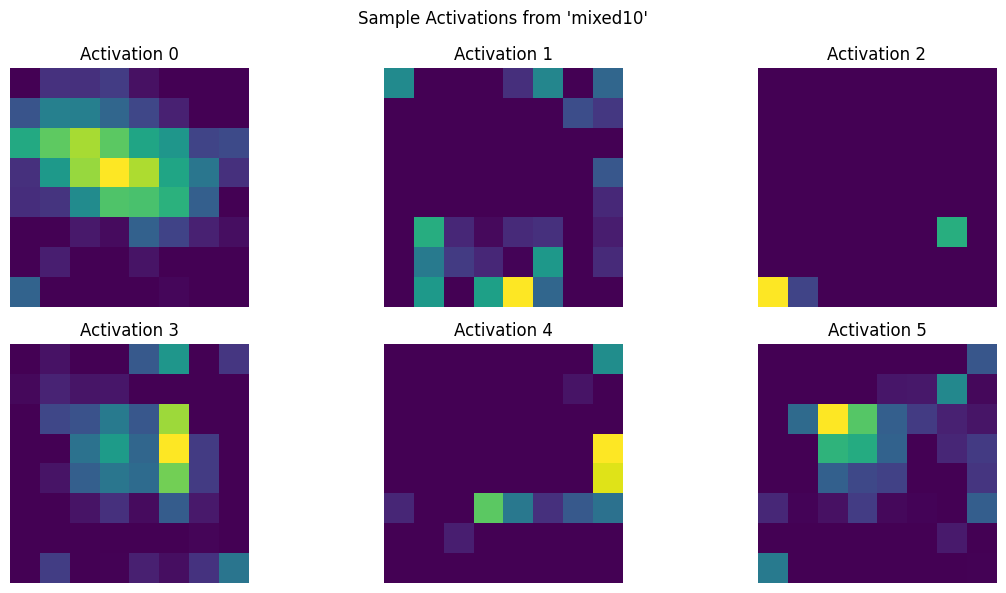

In [87]:
# Visualizing a few feature maps
activ_map = image_activations[0]  # shape: (H, W, C)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(activ_map[:, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f"Activation {i}")
plt.suptitle("Sample Activations from 'mixed10'")
plt.tight_layout()
plt.show()
